In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
import torch.nn.functional as F  # импортируем все библиотеки
from sklearn.model_selection import train_test_split
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from torch import nn, optim, tensor, Tensor
from IPython.display import clear_output
from tqdm import tqdm
import torchvision
from torchsummary import summary
from PIL import Image
import os
from torchvision import transforms
from torch.utils.data import random_split
from torchvision.transforms.v2 import Compose, PILToTensor, ToDtype, Normalize

In [3]:
class Xray_Mask_Dataloader(Dataset):
    def __init__(self, root_dir='yandex_ml_lunge/data'):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'train_images')
        self.label_dir = os.path.join(root_dir, 'train_lung_masks')

        self.image_list = os.listdir(self.image_dir)
        self.transform = transforms.Compose([
            PILToTensor(),
            ToDtype(torch.float32, scale=True)
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, f'img_{idx}.png')
        image = Image.open(img_name)
        image = self.transform(image)
        image = torch.cat([image, image, image], dim=0)

        label_name = os.path.join(self.label_dir, f'img_{idx}.png')
        label = Image.open(label_name)
        label = self.transform(label)

        return image.to(device), label.to(device)

In [6]:
xray_mask_dataset = Xray_Mask_Dataloader()
mask_train_set, mask_valid_set = random_split(xray_mask_dataset, (0.95, 0.05))

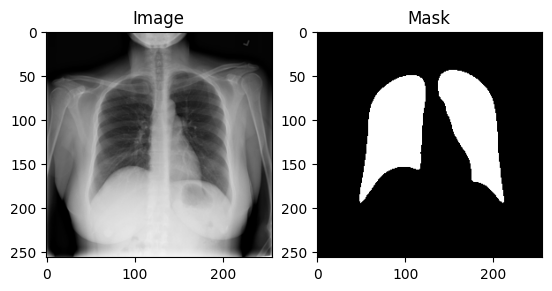

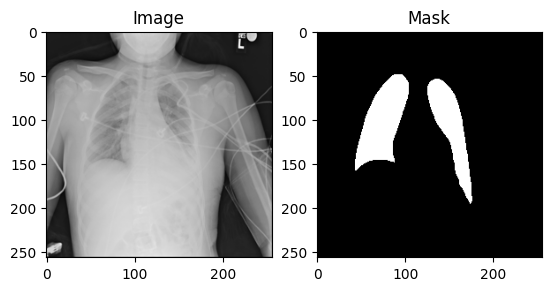

In [7]:
import matplotlib.pyplot as plt

for i in range(2):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(xray_mask_dataset[i][0].permute(1, 2, 0).cpu(), cmap='gray')
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(xray_mask_dataset[i][1].permute(1, 2, 0).cpu(), cmap='gray')
    plt.title('Mask')

    plt.show()

## U-net(Сегментация легких)

In [8]:
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2).to(device)
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        ).to(device)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, maxpool=True):
        super().__init__()

        if not maxpool:  # если не нужен макспулинг
            self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            ).to(device)

        else:  # если нужен макспулинг
            self.double_conv = nn.Sequential(
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            ).to(device)


    def forward(self, x):
        return self.double_conv(x)


class Step_Activation(nn.Module):
    def __init__(self):
        super(Step_Activation, self).__init__()
    
    def forward(self, x):
        x[x>=0] = 1
        x[x<0] = 0
        return x


class Out(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
            ).to(device)


    def forward(self, x):
        return self.out(x)


class Neural(nn.Module):
    def __init__(self, ran, is_summary_version=False):  # ran - количество блоков
        super().__init__()
        self.ran = ran
        self.is_summary_version = is_summary_version

        self.down = [Down(3, 64, maxpool=False)]

        self.up = []

        in_f = 32
        out_f = 64

        for i in range(self.ran - 1):
            in_f *= 2
            out_f *= 2
            self.down.append(Down(in_f, out_f))
        in_f *= 2
        out_f *= 2
        self.mid1 = Down(in_f, out_f)
        self.mid2 = Down(out_f, out_f * 2, maxpool=False)
        self.mid3 = Down(out_f * 2, out_f, maxpool=False)
        in_f, out_f = out_f, in_f

        for i in range(self.ran):
            self.up.append(Up(in_f, out_f))
            in_f //= 2
            out_f //= 2
        self.out = Out(64, 1)

    def forward(self, x):
        downs = [self.down[0](x)]
        for i in range(self.ran - 1):
            downs.append(self.down[i + 1](downs[i]))
        mid1 = self.mid1(downs[-1])
        mid2 = self.mid2(mid1)
        mid3 = self.mid3(mid2)
        up = self.up[0](mid3, downs[-1])
        ups = [up]
        for i in range(self.ran - 1):
            ups.append(self.up[i + 1](ups[i], downs[-(i + 2)]))
        out = self.out(ups[-1])

        if self.is_summary_version:
            print(*[i.size() for i in downs], sep='\n')
            print('medium')
            print(mid1.size())
            print(mid2.size())
            print(mid3.size())
            print('medium')
            print(*[i.size() for i in ups], sep='\n')
            print('out')
            print(out.size())

        return out

In [9]:
from torchvision import models
from torchsummary import summary

summary(Neural(2, is_summary_version=True), (3, 256, 256))

torch.Size([2, 64, 256, 256])
torch.Size([2, 128, 128, 128])
medium
torch.Size([2, 256, 64, 64])
torch.Size([2, 512, 64, 64])
torch.Size([2, 256, 64, 64])
medium
torch.Size([2, 128, 128, 128])
torch.Size([2, 64, 256, 256])
out
torch.Size([2, 1, 256, 256])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1          [-1, 128, 64, 64]               0
            Conv2d-2          [-1, 256, 64, 64]         295,168
       BatchNorm2d-3          [-1, 256, 64, 64]             512
         LeakyReLU-4          [-1, 256, 64, 64]               0
              Down-5          [-1, 256, 64, 64]               0
            Conv2d-6          [-1, 512, 64, 64]       1,180,160
       BatchNorm2d-7          [-1, 512, 64, 64]           1,024
         LeakyReLU-8          [-1, 512, 64, 64]               0
            Conv2d-9          [-1, 512, 64, 64]       2,359,808
      BatchNorm2d-10          [-1, 512,

### Коллбеки, Трейн цикл, Лосс

In [10]:
from IPython.display import clear_output
import numpy as np

def show_losses(train_loss_hist, test_loss_hist):
    clear_output()

    plt.figure(figsize=(12,4))

    plt.subplot(1, 2, 1)
    plt.title('Train Loss')
    plt.plot(np.arange(len(train_loss_hist)), train_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title('Test Loss')
    plt.plot(np.arange(len(test_loss_hist)), test_loss_hist)
    plt.yscale('log')
    plt.grid()

    plt.show()

graph of loss

In [11]:
from ignite.engine import create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, Metric

class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):     

        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):     
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth) / (inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets)
        Dice_BCE = BCE + dice_loss * 0.5
        
        return Dice_BCE

loss

In [12]:
model = Neural(2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = DiceBCELoss()
metrics = {
    "loss": Loss(DiceBCELoss()),
    "dice_loss": Loss(DiceLoss()),
    "bce_loss": Loss(nn.BCELoss())
}

In [13]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
train_evaluator = create_supervised_evaluator(model, metrics=metrics)
valid_evaluator = create_supervised_evaluator(model, metrics=metrics)

train_loader = DataLoader(mask_train_set, batch_size=8)
valid_loader = DataLoader(mask_valid_set, batch_size=8)

In [14]:
from ignite.engine import Events, Engine

PATH = 'segment_model.pth'
train_loss_hist = []
test_loss_hist = []

def log_iter_loss(engine):
    print(f"Epoch[{engine.state.epoch}] - Iter[{engine.state.iteration}]: loss = {engine.state.output}")

trainer.add_event_handler(Events.ITERATION_COMPLETED(every=10), log_iter_loss)

def compute_epoch_results(engine: Engine):
    train_evaluator.run(train_loader)
    valid_evaluator.run(valid_loader)

trainer.add_event_handler(Events.EPOCH_COMPLETED, compute_epoch_results)

def log_epoch_results(engine: Engine, label="", is_train=True):
    if is_train:
        train_loss_hist.append(engine.state.metrics['loss'])
    else:
        if test_loss_hist == [] or engine.state.metrics['loss'] < min(test_loss_hist):
            torch.save(model, PATH)
        test_loss_hist.append(engine.state.metrics['loss'])
    result = ', '.join([f"{m} = {v}" for m, v in engine.state.metrics.items()])
    print(f"{label} Res:", result)

train_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Train", is_train=True)
valid_evaluator.add_event_handler(Events.EPOCH_COMPLETED, log_epoch_results, label="Valid", is_train=False)

In [15]:
from ignite.handlers.param_scheduler import ReduceLROnPlateauScheduler

scheduler = ReduceLROnPlateauScheduler(
    optimizer,
    metric_name="loss",
    factor=0.5,
    patience=1,
    threshold=0.05
)

def print_lr():
    for param_group in optimizer.param_groups:
        print(f"Optimizer learning rate = {param_group['lr']}")

valid_evaluator.add_event_handler(Events.COMPLETED, scheduler)
valid_evaluator.add_event_handler(Events.COMPLETED, print_lr)

In [17]:
trainer.run(train_loader, 30)

Epoch[1] - Iter[10]: loss = 0.8480348587036133
Epoch[1] - Iter[20]: loss = 0.7574119567871094
Epoch[1] - Iter[30]: loss = 0.6858206987380981
Epoch[1] - Iter[40]: loss = 0.5953879952430725
Epoch[1] - Iter[50]: loss = 0.5692780613899231
Epoch[1] - Iter[60]: loss = 0.5338170528411865
Epoch[1] - Iter[70]: loss = 0.5047733783721924
Epoch[1] - Iter[80]: loss = 0.49579477310180664
Epoch[1] - Iter[90]: loss = 0.37097591161727905
Epoch[1] - Iter[100]: loss = 0.36570897698402405
Epoch[1] - Iter[110]: loss = 0.4636947810649872
Epoch[1] - Iter[120]: loss = 0.37453001737594604
Epoch[1] - Iter[130]: loss = 0.39372554421424866
Epoch[1] - Iter[140]: loss = 0.23823648691177368
Epoch[1] - Iter[150]: loss = 0.31288132071495056
Epoch[1] - Iter[160]: loss = 0.46873798966407776
Epoch[1] - Iter[170]: loss = 0.3569258451461792
Epoch[1] - Iter[180]: loss = 0.34535443782806396
Epoch[1] - Iter[190]: loss = 0.39477047324180603
Epoch[1] - Iter[200]: loss = 0.2603835463523865
Epoch[1] - Iter[210]: loss = 0.28798359

Engine run is terminating due to exception: 


KeyboardInterrupt: 

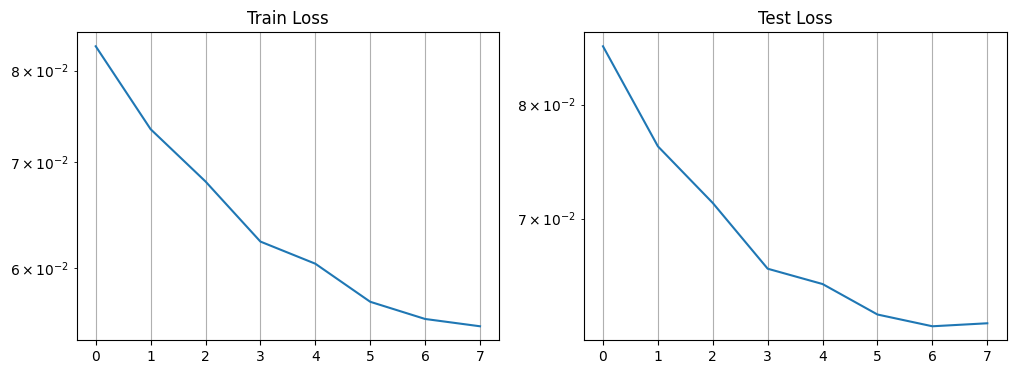

Min train loss: 0.055101611042580406
Min test loss: 0.06170672946506076


In [18]:
show_losses(train_loss_hist, test_loss_hist)
print(f'Min train loss: {min(train_loss_hist)}\nMin test loss: {min(test_loss_hist)}')

#### Post processing

In [19]:
import cv2
import numpy as np
from skimage import measure, color

def connected_component_filter(binary_mask, min_size_threshold=1200):
    labeled_mask = measure.label(binary_mask)
    unique_labels, label_sizes = np.unique(labeled_mask, return_counts=True)
    
    for label, size in zip(unique_labels, label_sizes):
        if size < min_size_threshold:
            binary_mask[labeled_mask == label] = 0
    
    return binary_mask

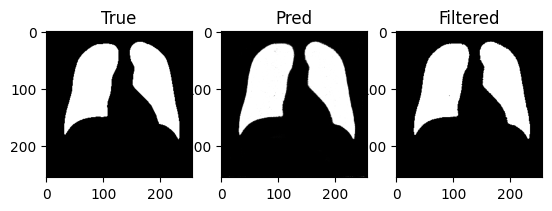

0.9868725538253784 --> 0.9901565313339233


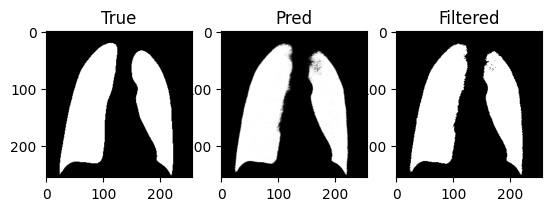

0.9686525464057922 --> 0.9760504961013794


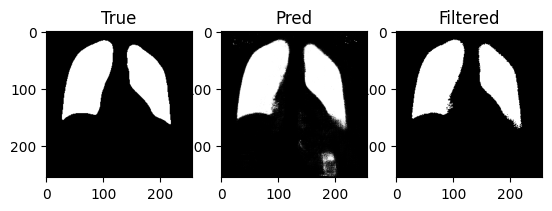

0.9537468552589417 --> 0.9752844572067261


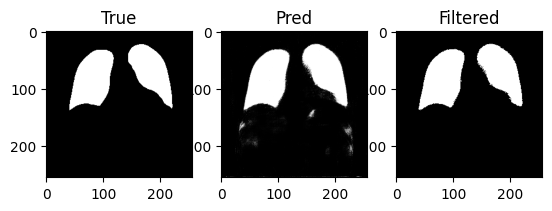

0.9529193043708801 --> 0.9763843417167664


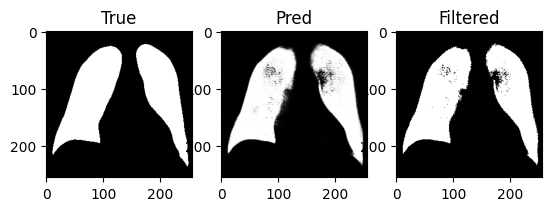

0.9445406198501587 --> 0.9601607322692871


In [20]:
with torch.no_grad():
    for i in range(5):
        model_ans = model(mask_valid_set[i][0].unsqueeze(0)).squeeze().cpu()
        filtered_mask = model_ans.numpy().copy()
        filtered_mask[filtered_mask>=0.4] = 1
        filtered_mask[filtered_mask<0.4] = 0
        filtered_mask = connected_component_filter(filtered_mask)

        true_ans = mask_valid_set[i][1].squeeze().cpu()
        plt.figure()
        plt.subplot(1, 3, 1)
        plt.imshow(true_ans, cmap='gray')
        plt.title('True')
        plt.subplot(1, 3, 2)
        plt.imshow(model_ans, cmap='gray')
        plt.title('Pred')
        plt.subplot(1, 3, 3)
        plt.imshow(filtered_mask, cmap='gray')

        plt.title('Filtered')
        plt.show()
        print(f'{1 - DiceLoss().forward(true_ans, model_ans)} --> {1 - DiceLoss().forward(true_ans, Tensor(filtered_mask))}')